In [18]:
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from src.utils import utils
importlib.reload(utils)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<module 'utils' from 'c:\\LocalData\\pabflore\\encoder-pacman\\utils.py'>

# Exploratory Data Analysis of Pacman gathered data (Updated to 2024-12-30)

In [8]:
## Read tables from csv
BANNED_USERS = [42]

user_df = pd.read_csv('data/user.csv')
ip_df = pd.read_csv('data/userip.csv')
redcap_df = pd.read_csv('data/redcapdata.csv')
game_df = pd.read_csv('data/game.csv', converters={'date_played': lambda x: pd.to_datetime(x)})
game_df = game_df[~game_df['user_id'].isin(BANNED_USERS)] # Remove user 42 (myself)
# game_df = game_df[game_df['user_id'] != 47]
gamestate_df = pd.read_csv('data/gamestate.csv', converters={'user_id': lambda x: int(x)})
gamestate_df = gamestate_df[~gamestate_df['game_id'].isin(game_df.loc[game_df['user_id'].isin(BANNED_USERS), 'game_id'])] # Remove games associated with userid 42 (myself)
psychometrics_df = pd.read_csv('data\psych\AiPerCogPacman_DATA_2025-03-03_0927.csv')


In [9]:
## Inspect data

user_df.info()
game_df.info()
gamestate_df.info()


user_df.head()
game_df.head()
gamestate_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   119 non-null    int64 
 1   username  119 non-null    object
 2   password  119 non-null    object
 3   email     119 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 656 entries, 4 to 661
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_id             656 non-null    int64         
 1   user_id             656 non-null    int64         
 2   session_number      656 non-null    int64         
 3   game_in_session     656 non-null    int64         
 4   total_games_played  656 non-null    int64         
 5   source              656 non-null    object        
 6   date_played         656 non-null    datetime64[ns]
 7   game_dura

,user_id,username,password,email
0,179,beans,$2y$10$b8XkCG8fnelJ4pIhbbfK/eVtfEgyTRcIWBj3M.B...,null@email.com
1,178,datxaban,$2y$10$X7ZNXqJb6upiYlDXjkbi9ObhcDXgYRjdTrP.CLc...,null@email.com
2,177,baea,$2y$10$t/vxMBXRulMaFN01r5sXWuln4Ys7TaskLZ6hv3A...,null@email.com
3,176,Garen,$2y$10$I0DvZJlSFXm5XmjwmCrjVOPyq/ISLwk0EXO8h2y...,null@email.com
4,175,teehee1234,$2y$10$Dl7JZd/q8bu8x.RHWlYbP.1q9R8VGzHpeZD981z...,null@email.com


,game_id,user_id,session_number,game_in_session,total_games_played,source,date_played,game_duration,win,level
4,388,64,1,1,1,DataGathering,2024-11-29 14:13:35,75.874,1,1
5,389,64,1,2,2,DataGathering,2024-11-29 14:14:58,14.981,0,2
6,390,64,1,3,3,DataGathering,2024-11-29 14:15:57,55.516,1,1
7,391,64,1,4,4,DataGathering,2024-11-29 14:17:00,48.834,0,2
8,392,64,1,5,5,DataGathering,2024-11-29 14:18:12,80.657,1,1


,game_state_id,game_id,time_elapsed,score,lives,pacman_attack,input_direction,movement_direction,Pacman_X,Pacman_Y,...,ghost3_state,ghost4_state,powerPellets,pellets,powerpelletstate_1,powerpelletstate_2,powerpelletstate_3,powerpelletstate_4,fruitState_1,fruitState_2
0,214062,382,0.19,0,3,0,NaN,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
1,214063,382,0.23,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
2,214064,382,0.29,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
3,214065,382,0.33,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
4,214066,382,0.39,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0


In [10]:
game_df[['game_duration']].describe()


,game_duration
count,656.000000
mean,58.949459
std,40.145930
min,4.155000
25%,46.617750
50%,59.748000
75%,72.214750
max,933.101000


In [20]:
# Aggregated data per participant 
agg= game_df.groupby('user_id').agg({'game_duration': 'mean', 'level': 'max', 'game_id': 'count', 'game_in_session': 'max', 'session_number': 'max', 'win': 'sum'})

agg['winrate'] = agg['win'] / agg['game_id']

agg.rename(columns={'game_duration': 'avg_game_duration', 'level': 'max_level', 'game_id': 'games_played', 'game_in_session': 'longest_session', 'session_number': 'amount_sessions', 'win': 'wins'}, inplace=True)

agg.sort_values(by='games_played', ascending=False)

agg.describe()



,avg_game_duration,max_level,games_played,longest_session,amount_sessions,wins,winrate
user_id,,,,,,,
74,62.465310,4,71,23,12,36,0.507042
78,56.279762,3,42,17,5,15,0.357143
73,58.233405,3,37,37,1,15,0.405405
91,51.758030,4,33,33,1,17,0.515152
157,63.527032,4,31,25,2,13,0.419355
...,...,...,...,...,...,...,...
114,65.185000,1,1,1,1,0,0.000000
125,44.623000,1,1,1,1,0,0.000000
118,58.450000,1,1,1,1,0,0.000000


,avg_game_duration,max_level,games_played,longest_session,amount_sessions,wins,winrate
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,61.452982,2.237500,8.200000,6.425000,1.487500,3.462500,0.334934
std,25.601492,1.161009,10.665691,6.785642,1.501002,5.439992,0.257465
min,41.476714,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,52.402008,1.000000,3.000000,3.000000,1.000000,0.000000,0.000000
50%,58.387733,2.000000,5.000000,4.000000,1.000000,1.500000,0.400000
75%,65.765696,3.000000,8.750000,6.000000,1.000000,4.000000,0.500000
max,272.720750,5.000000,71.000000,37.000000,12.000000,36.000000,0.800000


(array([28., 19., 10.,  3.,  6.,  3.,  5.,  1.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 1.        ,  3.33333333,  5.66666667,  8.        , 10.33333333,
        12.66666667, 15.        , 17.33333333, 19.66666667, 22.        ,
        24.33333333, 26.66666667, 29.        , 31.33333333, 33.66666667,
        36.        , 38.33333333, 40.66666667, 43.        , 45.33333333,
        47.66666667, 50.        , 52.33333333, 54.66666667, 57.        ,
        59.33333333, 61.66666667, 64.        , 66.33333333, 68.66666667,
        71.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Number of Games Played')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Games Played per User')

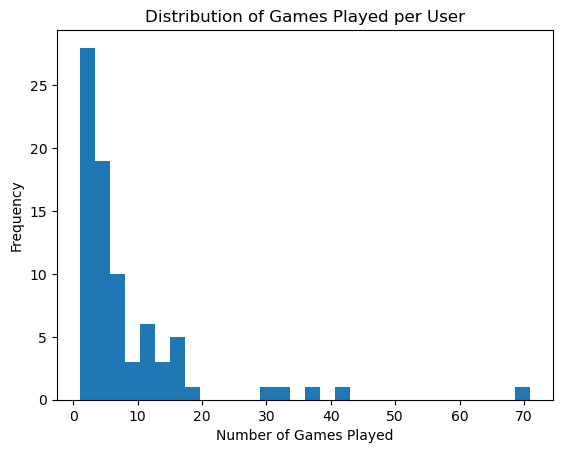

In [21]:
# Descriptive statistic of main variables.

# Distribution of games played per user
import matplotlib.pyplot as plt

user_game_counts = game_df.groupby('user_id').size()
plt.hist(user_game_counts, bins=30)
plt.xlabel('Number of Games Played')
plt.ylabel('Frequency')
plt.title('Distribution of Games Played per User')
plt.show()


In [23]:
game_df.loc[game_df['game_duration'] > 500, 'game_id']


35    419
Name: game_id, dtype: int64

An outlier in game duration was identified. This is game id 419, and it was probably due to a bug (game freeze?).

(array([ 4., 16., 19.,  9., 19.,  9.,  7., 17., 21., 19., 31., 37., 55.,
        51., 57., 48., 49., 59., 32., 39., 21., 10., 11.,  5.,  5.,  3.,
         0.,  1.,  0.,  1.]),
 array([  4.155     ,   8.07776667,  12.00053333,  15.9233    ,
         19.84606667,  23.76883333,  27.6916    ,  31.61436667,
         35.53713333,  39.4599    ,  43.38266667,  47.30543333,
         51.2282    ,  55.15096667,  59.07373333,  62.9965    ,
         66.91926667,  70.84203333,  74.7648    ,  78.68756667,
         82.61033333,  86.5331    ,  90.45586667,  94.37863333,
         98.3014    , 102.22416667, 106.14693333, 110.0697    ,
        113.99246667, 117.91523333, 121.838     ]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Game Duration')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Game Duration (less than 500)')

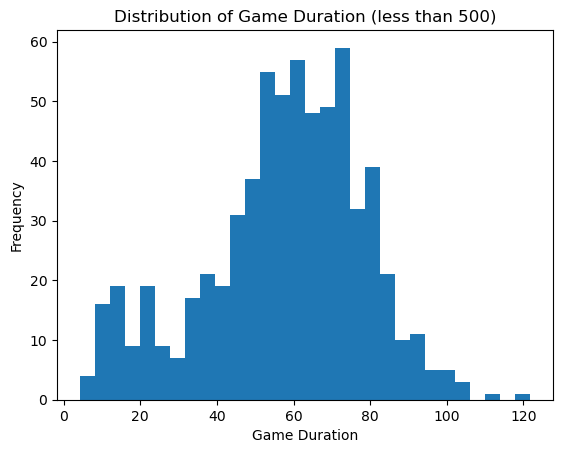

In [24]:

# Distribution of game duration
import matplotlib.pyplot as plt

plt.hist(game_df.loc[game_df['game_duration'] < 500, 'game_duration'], bins=30)
plt.xlabel('Game Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Game Duration (less than 500)')
plt.show()


In [25]:
# Distribution of games played per level
game_df.groupby('level').size()



level
1    383
2    192
3     55
4     22
5      4
dtype: int64

In [71]:
random_record_id = psychometrics_df['record_id'].sample(n=1).iloc[0]
psychometrics_df.loc[psychometrics_df['record_id'] == random_record_id]


,record_id,redcap_repeat_instrument,redcap_repeat_instance,redcap_survey_identifier,consent_timestamp,name,email,age,gender,gender_other,...,total_games_flow,fss_1,fss_2,fss_3,fss_4,fss_5,fss_6,fss_7,fss_8,flow_complete
290,102,NaN,NaN,NaN,2024-12-17 08:35:45,anbopan,panjiaen.c@gmail.com,21.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,102,flow,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,5.0,4.0,4.0,3.0,3.0,6.0,6.0,4.0,2.0
292,102,flow,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,5.0,4.0,4.0,2.0,5.0,6.0,5.0,2.0
293,102,flow,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,5.0,4.0,5.0,3.0,4.0,5.0,5.0,2.0
294,102,flow,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,4.0,5.0,5.0,6.0,4.0,5.0,6.0,6.0,2.0


In [72]:
bisbas_df = psychometrics_df.loc[~psychometrics_df['redcap_repeat_instrument'].isin(['flow','sam']) & psychometrics_df['consent_timestamp'].notna() & (psychometrics_df['record_id'] > 60)]

bisbas_df = bisbas_df.iloc[:,5:34]

bisbas_df.describe()


,age,gender,gender_other,edu,experience,consent_answer,bis_1,bis_2,bis_3,bis_4,...,rew_4,rew_5,drive_1,drive_2,drive_3,drive_4,fun_1,fun_2,fun_3,fun_4
count,88.000000,88.000000,0.0,88.000000,83.000000,88.000000,87.000000,87.000000,87.000000,87.000000,...,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,28.943182,1.738636,NaN,4.329545,1.168675,0.988636,2.873563,3.114943,3.011494,3.264368,...,3.356322,3.149425,2.586207,2.574713,2.528736,2.000000,2.712644,2.862069,3.022989,2.517241
std,7.821806,0.702938,NaN,0.967537,0.376741,0.106600,0.774666,0.753678,0.739174,0.799124,...,0.698454,0.770514,0.755626,0.830133,0.760035,0.777593,0.874816,0.780167,0.698454,0.744937
min,20.000000,1.000000,NaN,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,24.000000,1.000000,NaN,4.000000,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,3.000000,2.000000
50%,27.000000,2.000000,NaN,4.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000
75%,31.250000,2.000000,NaN,5.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000
max,59.000000,4.000000,NaN,6.000000,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
